# Analyze Movies
This file is prepared to load some data about movies (1.3Mb JSON). It contains the following data about movies:

| Property | Type | Records with null |
|---|---|---|
| Title | String | 1 |
| US Gross | USD | 7 |
| Worldwide Gross | USD | 7 |
| US DVD Sales | USD | 2637 |
| Production Budget | USD | 1 |
| Release Date | MMM D YYYY | 0 |
| MPAA Rating | String | 605 |
| Running Time min | Integer Minutes | 1992 |
| Distributor | String | 232 |
| Source | String | 365 |
| Major Genre | String | 275 |
| Creative Type | String | 446 |
| Director | String | 1331 |
| Rotten Tomatoes Rating | Decimal (0-100) | 880 |
| IMDB Rating | Decimal (0-10) | 213 |
| IMDB Votes | Integer | 213 |

---
# Load the data
Run the cell below once to load all movies data in a Pandas Dataframe. Consider a Dataframe as a Table on Steroids.

In [1]:
import pandas as pd

# Load the movies data into a DataFrame
movies_url = "https://raw.githubusercontent.com/himmelreich-it/jupyter-teaser-workshop/refs/heads/main/movies.json"
df = pd.read_json(movies_url)

df.head()

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


---
# Directors with the most movies
Find the top 10 directors with the most movies in this file.

In [2]:
# Find top 10 directors by number of movies
# First, let's check how many movies have director information
movies_with_directors = df[df['Director'].notna()]
print(f"Total movies in dataset: {len(df)}")
print(f"Movies with director information: {len(movies_with_directors)}")
print(f"Movies without director information: {len(df) - len(movies_with_directors)}")

# Count movies per director
director_counts = movies_with_directors['Director'].value_counts()

# Get top 10 directors
director_counts = director_counts.reset_index()
director_counts.head(10)


Total movies in dataset: 3201
Movies with director information: 1870
Movies without director information: 1331


,Director,count
0,Steven Spielberg,23
1,Woody Allen,16
2,Spike Lee,15
3,Martin Scorsese,15
4,Ridley Scott,14
5,Brian De Palma,13
6,Francis Ford Coppola,13
7,Renny Harlin,12
8,Steven Soderbergh,12
9,Joel Schumacher,12


# Budget Statistics per Year
# Extract year from Release Date and calculate budget statistics

# First, let's examine the data structure and clean it
print("Production Budget data overview:")
print(f"Total movies: {len(df)}")
print(f"Movies with budget data: {df['Production Budget'].notna().sum()}")
print(f"Movies without budget data: {df['Production Budget'].isna().sum()}")
print(f"Budget range: ${df['Production Budget'].min():,.0f} - ${df['Production Budget'].max():,.0f}")

# Extract year from Release Date
df['Release Year'] = pd.to_datetime(df['Release Date']).dt.year

# Filter movies with valid budget and year data
budget_data = df[(df['Production Budget'].notna()) & (df['Production Budget'] > 0) & (df['Release Year'].notna())]

print(f"\nMovies with valid budget and year data: {len(budget_data)}")
print(f"Year range: {budget_data['Release Year'].min():.0f} - {budget_data['Release Year'].max():.0f}")

# Calculate budget statistics per year
budget_stats = budget_data.groupby('Release Year')['Production Budget'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Min', 'min'), 
    ('Max', 'max')
]).reset_index()

# Format the budget columns for better readability
budget_stats['Mean'] = budget_stats['Mean'].apply(lambda x: f"${x:,.0f}")
budget_stats['Min'] = budget_stats['Min'].apply(lambda x: f"${x:,.0f}")
budget_stats['Max'] = budget_stats['Max'].apply(lambda x: f"${x:,.0f}")

# Rename columns for clarity
budget_stats.columns = ['Year', 'Movies Count', 'Average Budget', 'Min Budget', 'Max Budget']

# Display the complete table
print("\n" + "="*80)
print("BUDGET STATISTICS PER YEAR")
print("="*80)
budget_stats

---
# Highest rated movie below 100,000 USD
Question could be considered ambiguous, define highest rating. Below it is defined as:
Mean of IMDB and (RT/10), skip if not available.

In [11]:
# Define columns to display
display_columns = ['Title', 'Director', 'Release Date','Production Budget', 'IMDB Rating', 'Rotten Tomatoes Rating', 'Combined_rating']

# Create normalized versions of both ratings
# IMDB is already 0-10, so no change needed
df['IMDB_normalized'] = df['IMDB Rating']

# Convert Rotten Tomatoes from 0-100 to 0-10 scale
df['RT_normalized'] = df['Rotten Tomatoes Rating'] / 10

# Create a combined rating (average of both when both are available)
df['Combined_rating'] = df[['IMDB_normalized', 'RT_normalized']].mean(axis=1)

# Show the normalization
comparison = df[['Title', 'IMDB Rating', 'Rotten Tomatoes Rating', 
                'IMDB_normalized', 'RT_normalized', 'Combined_rating']].head(10)

# Filter movies under $100k
low_budget = df[(df['Production Budget'] < 100000) & (df['Production Budget'] > 0)]

# Find highest by combined rating
best_combined = low_budget.dropna(subset=['Combined_rating']).nlargest(1, 'Combined_rating').reset_index()

best_combined_short = best_combined[display_columns]
best_combined_short.head(1)

,Title,Director,Release Date,Production Budget,IMDB Rating,Rotten Tomatoes Rating,Combined_rating
0,Return to the Land of Wonders,None,Jul 13 2005,5000.0,8.5,NaN,8.5


In [12]:
# Find highest by IMDB
best_imdb = low_budget.dropna(subset=['IMDB_normalized']).nlargest(1, 'IMDB_normalized')
best_imdb_short = best_imdb[display_columns]
best_imdb_short.head(1)

,Title,Director,Release Date,Production Budget,IMDB Rating,Rotten Tomatoes Rating,Combined_rating
802,Return to the Land of Wonders,None,Jul 13 2005,5000.0,8.5,NaN,8.5


In [13]:
best_rt = low_budget.dropna(subset=['RT_normalized']).nlargest(1, 'RT_normalized')
best_rt_short = best_rt[display_columns]
best_rt_short.head(1)

,Title,Director,Release Date,Production Budget,IMDB Rating,Rotten Tomatoes Rating,Combined_rating
132,The Brothers McMullen,Edward Burns,Aug 09 1995,25000.0,6.4,91.0,7.75


---
# Do longer movies get a better rating
Is there a correlation between IMDB Rating and the Length of the Movie...

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Clean the data - remove rows where either Running Time or IMDB Rating is missing
clean_data = df.dropna(subset=['Running Time min', 'IMDB Rating'])

print(f"Total movies with both Running Time and IMDB Rating: {len(clean_data)}")
print(f"Running Time range: {clean_data['Running Time min'].min():.0f} - {clean_data['Running Time min'].max():.0f} minutes")
print(f"IMDB Rating range: {clean_data['IMDB Rating'].min():.1f} - {clean_data['IMDB Rating'].max():.1f}")

Total movies with both Running Time and IMDB Rating: 1146
Running Time range: 46 - 222 minutes
IMDB Rating range: 1.7 - 9.1



Pearson Correlation Coefficient: 0.3875
P-value: 0.0000
Relationship strength: Moderate


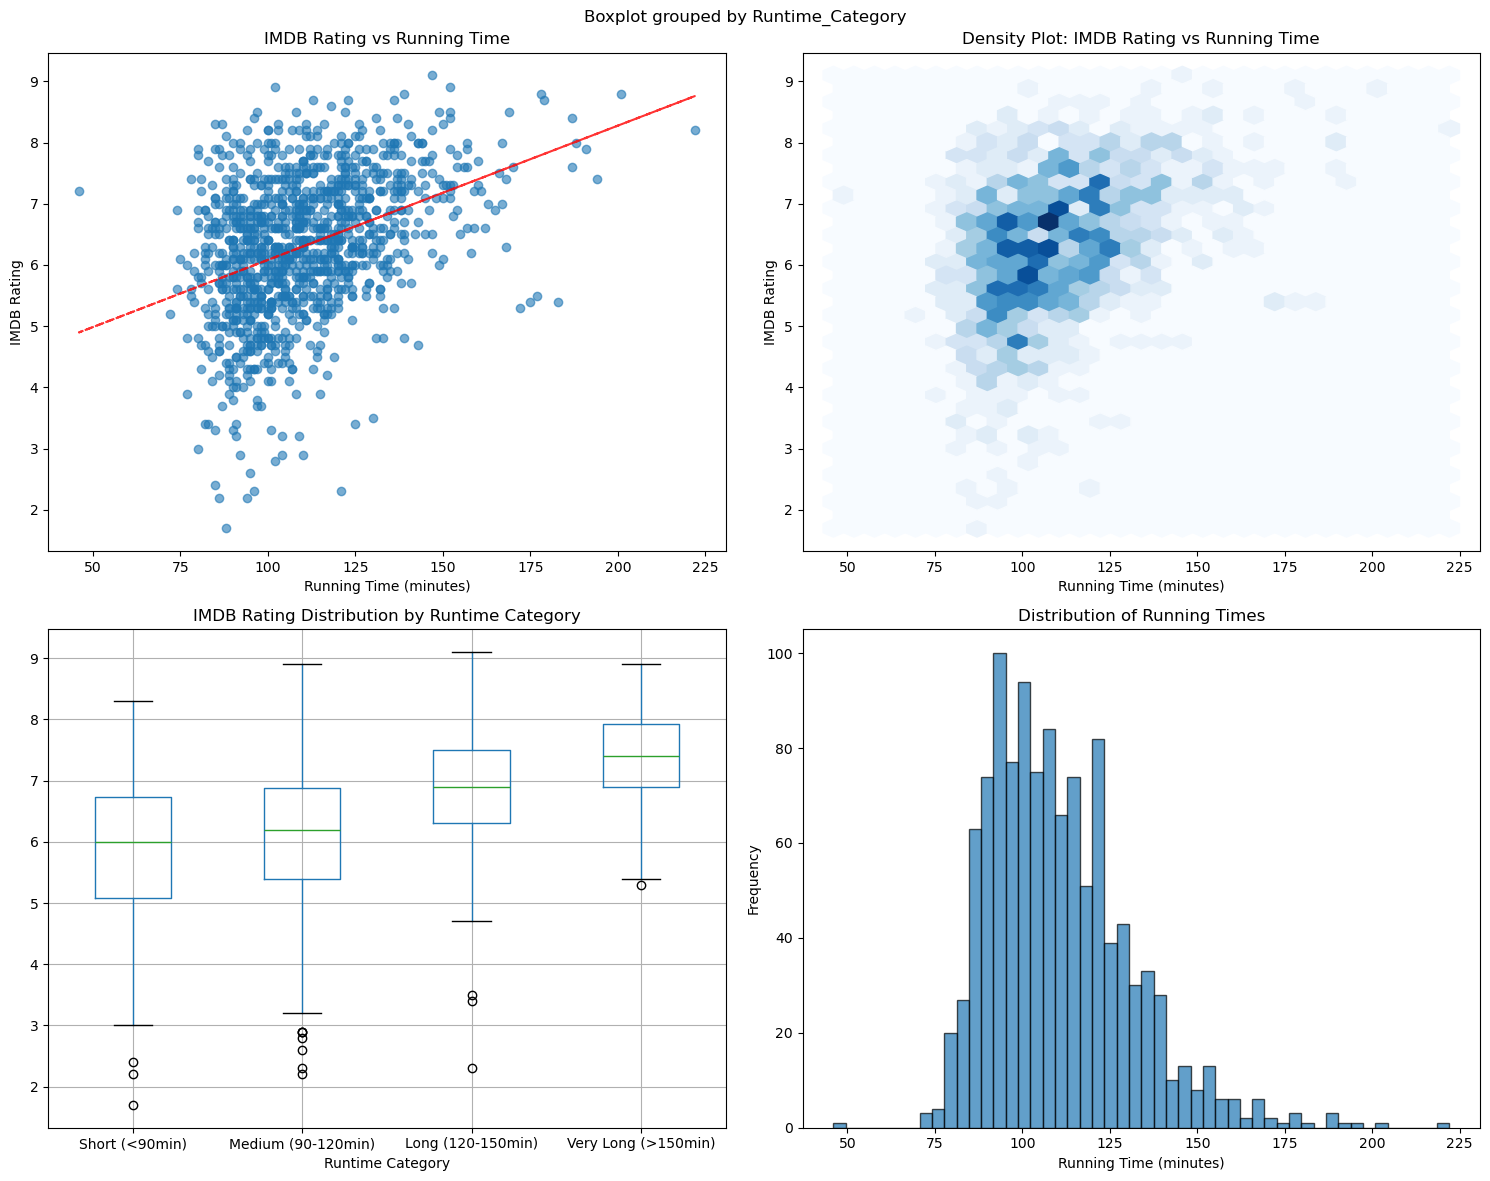

In [22]:
# Calculate Pearson correlation coefficient
correlation, p_value = stats.pearsonr(clean_data['Running Time min'], clean_data['IMDB Rating'])

print(f"\nPearson Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Relationship strength: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'}")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot
axes[0,0].scatter(clean_data['Running Time min'], clean_data['IMDB Rating'], alpha=0.6)
axes[0,0].set_xlabel('Running Time (minutes)')
axes[0,0].set_ylabel('IMDB Rating')
axes[0,0].set_title('IMDB Rating vs Running Time')

# Add trend line
z = np.polyfit(clean_data['Running Time min'], clean_data['IMDB Rating'], 1)
p = np.poly1d(z)
axes[0,0].plot(clean_data['Running Time min'], p(clean_data['Running Time min']), "r--", alpha=0.8)

# Hexbin plot for density
axes[0,1].hexbin(clean_data['Running Time min'], clean_data['IMDB Rating'], gridsize=30, cmap='Blues')
axes[0,1].set_xlabel('Running Time (minutes)')
axes[0,1].set_ylabel('IMDB Rating')
axes[0,1].set_title('Density Plot: IMDB Rating vs Running Time')

# Box plot by running time categories
# Create running time categories
clean_data_copy = clean_data.copy()
clean_data_copy['Runtime_Category'] = pd.cut(clean_data_copy['Running Time min'], 
                                           bins=[0, 90, 120, 150, 300], 
                                           labels=['Short (<90min)', 'Medium (90-120min)', 
                                                  'Long (120-150min)', 'Very Long (>150min)'])

clean_data_copy.boxplot(column='IMDB Rating', by='Runtime_Category', ax=axes[1,0])
axes[1,0].set_title('IMDB Rating Distribution by Runtime Category')
axes[1,0].set_xlabel('Runtime Category')

# Distribution of running times
axes[1,1].hist(clean_data['Running Time min'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Running Time (minutes)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Running Times')

plt.tight_layout()
plt.show()

Conclusion: we cannot say, given the data we have...